<a href="https://colab.research.google.com/github/ssc30/DesignOptimization2021Fall/blob/main/Project/DO_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

%%%Due to some issue I can't push the files from my laptop but can only push through colab so here is the Matlab code for Project 3. Sorry for the inconvinence.%%%

In [ ]:
nelx=200;
nely=40;
volfrac=0.4;
rmin=3.0;
penal=3.0;
ft=1;
top88(nelx,nely,volfrac,penal,rmin,ft)

function top88(nelx,nely,volfrac,penal,rmin,ft)
  %% MATERIAL PROPERTIES
  E0 = 1;
  Emin = 1e-9;
  nu = 0.3;
  %% PREPARE FINITE ELEMENT ANALYSIS
  A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12];
  A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6];
  B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4];
  B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2];
  KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11]);
  nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx);
  edofVec = reshape(2*nodenrs(1:end-1,1:end-1)+1,nelx*nely,1);
  edofMat = repmat(edofVec,1,8)+repmat([0 1 2*nely+[2 3 0 1] -2 -1],nelx*nely,1);
  iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);
  jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);
  % DEFINE LOADS AND SUPPORTS (HALF MBB-BEAM)
  F = sparse(2,1,-1,2*(nely+1)*(nelx+1),1);
  U = zeros(2*(nely+1)*(nelx+1),1);
  fixeddofs = union([1:2:2*(nely+1)],[2*(nelx+1)*(nely+1)]);
  alldofs = [1:2*(nely+1)*(nelx+1)];
  freedofs = setdiff(alldofs,fixeddofs);
  %% PREPARE FILTER
  iH = ones(nelx*nely*(2*(ceil(rmin)-1)+1)^2,1);
  jH = ones(size(iH));
  sH = zeros(size(iH));
  k = 0;
  for i1 = 1:nelx
    for j1 = 1:nely
      e1 = (i1-1)*nely+j1;
      for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
        for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
          e2 = (i2-1)*nely+j2;
          k = k+1;
          iH(k) = e1;
          jH(k) = e2;
          sH(k) = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
        end
      end
    end
  end
  H = sparse(iH,jH,sH);
  Hs = sum(H,2);
  %% INITIALIZE ITERATION
  x = repmat(volfrac,nely,nelx);
  xPhys = x;
  loop = 0;
  change = 1;
  %% START ITERATION
  while change > 0.01
    loop = loop + 1;
    %% FE-ANALYSIS
    sK = reshape(KE(:)*(Emin+xPhys(:)'.^penal*(E0-Emin)),64*nelx*nely,1);
    K = sparse(iK,jK,sK); K = (K+K')/2;
    U(freedofs) = K(freedofs,freedofs)\F(freedofs);
    %% OBJECTIVE FUNCTION AND SENSITIVITY ANALYSIS
    ce = reshape(sum((U(edofMat)*KE).*U(edofMat),2),nely,nelx);
    c = sum(sum((Emin+xPhys.^penal*(E0-Emin)).*ce));
    dc = -penal*(E0-Emin)*xPhys.^(penal-1).*ce;
    dv = ones(nely,nelx);
    %% FILTERING/MODIFICATION OF SENSITIVITIES
    if ft == 1
      dc(:) = H*(x(:).*dc(:))./Hs./max(1e-3,x(:));
    elseif ft == 2
      dc(:) = H*(dc(:)./Hs);
      dv(:) = H*(dv(:)./Hs);
    end
    %% OPTIMALITY CRITERIA UPDATE OF DESIGN VARIABLES AND PHYSICAL DENSITIES
    l1 = 0; l2 = 1e9; move = 0.2;
    while (l2-l1)/(l1+l2) > 1e-3
      lmid = 0.5*(l2+l1);
      xnew = max(0,max(x-move,min(1,min(x+move,x.*sqrt(-dc./dv/lmid)))));
      if ft == 1
        xPhys = xnew;
      elseif ft == 2
        xPhys(:) = (H*xnew(:))./Hs;
      end
      if sum(xPhys(:)) > volfrac*nelx*nely, l1 = lmid; else l2 = lmid; end
    end
    change = max(abs(xnew(:)-x(:)));
    x = xnew;
    %% PRINT RESULTS
    fprintf(' It.:%5i Obj.:%11.4f Vol.:%7.3f ch.:%7.3f\n',loop,c, ...
      mean(xPhys(:)),change);
    %% PLOT DENSITIES
    colormap(gray); imagesc(1-xPhys); caxis([0 1]); axis equal; axis off; drawnow;
  end
end

In [ ]:
# The Output of the program is as follows:
# It.:    1 Obj.:  8203.6509 Vol.:  0.400 ch.:  0.200
#  It.:    2 Obj.:  3906.9130 Vol.:  0.400 ch.:  0.200
#  It.:    3 Obj.:  2515.3522 Vol.:  0.400 ch.:  0.200
#  It.:    4 Obj.:  1872.1904 Vol.:  0.400 ch.:  0.200
#  It.:    5 Obj.:  1669.2506 Vol.:  0.400 ch.:  0.200
#  It.:    6 Obj.:  1598.3732 Vol.:  0.400 ch.:  0.200
#  It.:    7 Obj.:  1565.0779 Vol.:  0.400 ch.:  0.147
#  It.:    8 Obj.:  1534.5703 Vol.:  0.400 ch.:  0.200
#  It.:    9 Obj.:  1510.2212 Vol.:  0.400 ch.:  0.145
#  It.:   10 Obj.:  1484.3842 Vol.:  0.400 ch.:  0.191
#  It.:   11 Obj.:  1465.2018 Vol.:  0.400 ch.:  0.155
#  It.:   12 Obj.:  1441.0260 Vol.:  0.400 ch.:  0.192
#  It.:   13 Obj.:  1420.4228 Vol.:  0.400 ch.:  0.160
#  It.:   14 Obj.:  1395.1155 Vol.:  0.400 ch.:  0.186
#  It.:   15 Obj.:  1367.7005 Vol.:  0.400 ch.:  0.157
#  It.:   16 Obj.:  1333.7160 Vol.:  0.400 ch.:  0.186
#  It.:   17 Obj.:  1297.9154 Vol.:  0.400 ch.:  0.158
#  It.:   18 Obj.:  1261.8565 Vol.:  0.400 ch.:  0.171
#  It.:   19 Obj.:  1230.1809 Vol.:  0.400 ch.:  0.150
#  It.:   20 Obj.:  1198.4006 Vol.:  0.400 ch.:  0.162
#  It.:   21 Obj.:  1162.3131 Vol.:  0.400 ch.:  0.153
#  It.:   22 Obj.:  1119.6516 Vol.:  0.400 ch.:  0.169
#  It.:   23 Obj.:  1073.8391 Vol.:  0.400 ch.:  0.175
#  It.:   24 Obj.:  1037.6615 Vol.:  0.400 ch.:  0.174
#  It.:   25 Obj.:  1009.9071 Vol.:  0.400 ch.:  0.174
#  It.:   26 Obj.:   988.6510 Vol.:  0.400 ch.:  0.152
#  It.:   27 Obj.:   968.3836 Vol.:  0.400 ch.:  0.149
#  It.:   28 Obj.:   955.2009 Vol.:  0.400 ch.:  0.123
#  It.:   29 Obj.:   946.9401 Vol.:  0.400 ch.:  0.100
#  It.:   30 Obj.:   943.4011 Vol.:  0.400 ch.:  0.063
#  It.:   31 Obj.:   943.2103 Vol.:  0.400 ch.:  0.058
#  It.:   32 Obj.:   942.7025 Vol.:  0.400 ch.:  0.049
#  It.:   33 Obj.:   941.8111 Vol.:  0.400 ch.:  0.047
#  It.:   34 Obj.:   942.3024 Vol.:  0.400 ch.:  0.045
#  It.:   35 Obj.:   941.0346 Vol.:  0.400 ch.:  0.043
#  It.:   36 Obj.:   940.9180 Vol.:  0.400 ch.:  0.042
#  It.:   37 Obj.:   940.1758 Vol.:  0.400 ch.:  0.042
#  It.:   38 Obj.:   940.5680 Vol.:  0.400 ch.:  0.043
#  It.:   39 Obj.:   939.1816 Vol.:  0.400 ch.:  0.042
#  It.:   40 Obj.:   938.7949 Vol.:  0.400 ch.:  0.043
#  It.:   41 Obj.:   938.5602 Vol.:  0.400 ch.:  0.042
#  It.:   42 Obj.:   938.5076 Vol.:  0.400 ch.:  0.046
#  It.:   43 Obj.:   937.6774 Vol.:  0.400 ch.:  0.043
#  It.:   44 Obj.:   936.8858 Vol.:  0.400 ch.:  0.046
#  It.:   45 Obj.:   936.2078 Vol.:  0.400 ch.:  0.046
#  It.:   46 Obj.:   935.1458 Vol.:  0.400 ch.:  0.052
#  It.:   47 Obj.:   934.6229 Vol.:  0.400 ch.:  0.052
#  It.:   48 Obj.:   934.2464 Vol.:  0.400 ch.:  0.057
#  It.:   49 Obj.:   933.6017 Vol.:  0.400 ch.:  0.058
#  It.:   50 Obj.:   932.4382 Vol.:  0.400 ch.:  0.063
#  It.:   51 Obj.:   931.0430 Vol.:  0.400 ch.:  0.062
#  It.:   52 Obj.:   930.8897 Vol.:  0.400 ch.:  0.069
#  It.:   53 Obj.:   929.0651 Vol.:  0.400 ch.:  0.071
#  It.:   54 Obj.:   928.0845 Vol.:  0.400 ch.:  0.077
#  It.:   55 Obj.:   926.0091 Vol.:  0.400 ch.:  0.083
#  It.:   56 Obj.:   924.6207 Vol.:  0.400 ch.:  0.092
#  It.:   57 Obj.:   921.6074 Vol.:  0.400 ch.:  0.091
#  It.:   58 Obj.:   918.7706 Vol.:  0.400 ch.:  0.092
#  It.:   59 Obj.:   914.4106 Vol.:  0.400 ch.:  0.086
#  It.:   60 Obj.:   911.5589 Vol.:  0.400 ch.:  0.074
#  It.:   61 Obj.:   910.7932 Vol.:  0.400 ch.:  0.050
#  It.:   62 Obj.:   910.5044 Vol.:  0.400 ch.:  0.054
#  It.:   63 Obj.:   910.0131 Vol.:  0.400 ch.:  0.077
#  It.:   64 Obj.:   909.7895 Vol.:  0.400 ch.:  0.068
#  It.:   65 Obj.:   910.3800 Vol.:  0.400 ch.:  0.048
#  It.:   66 Obj.:   910.2169 Vol.:  0.400 ch.:  0.063
#  It.:   67 Obj.:   910.2977 Vol.:  0.400 ch.:  0.070
#  It.:   68 Obj.:   910.2069 Vol.:  0.400 ch.:  0.075
#  It.:   69 Obj.:   910.1996 Vol.:  0.400 ch.:  0.075
#  It.:   70 Obj.:   910.1353 Vol.:  0.400 ch.:  0.056
#  It.:   71 Obj.:   910.1019 Vol.:  0.400 ch.:  0.036
#  It.:   72 Obj.:   910.0472 Vol.:  0.400 ch.:  0.022
#  It.:   73 Obj.:   910.0128 Vol.:  0.400 ch.:  0.015
#  It.:   74 Obj.:   909.9640 Vol.:  0.400 ch.:  0.013
#  It.:   75 Obj.:   909.9305 Vol.:  0.400 ch.:  0.018
#  It.:   76 Obj.:   909.8920 Vol.:  0.400 ch.:  0.018
#  It.:   77 Obj.:   909.8586 Vol.:  0.400 ch.:  0.014
#  It.:   78 Obj.:   909.8246 Vol.:  0.400 ch.:  0.022
#  It.:   79 Obj.:   909.7915 Vol.:  0.400 ch.:  0.022
#  It.:   80 Obj.:   909.7541 Vol.:  0.400 ch.:  0.016
#  It.:   81 Obj.:   909.7254 Vol.:  0.400 ch.:  0.026
#  It.:   82 Obj.:   908.9138 Vol.:  0.400 ch.:  0.027
#  It.:   83 Obj.:   909.7193 Vol.:  0.400 ch.:  0.021
#  It.:   84 Obj.:   909.4586 Vol.:  0.400 ch.:  0.039
#  It.:   85 Obj.:   909.6302 Vol.:  0.400 ch.:  0.043
#  It.:   86 Obj.:   909.5199 Vol.:  0.400 ch.:  0.033
#  It.:   87 Obj.:   908.8075 Vol.:  0.400 ch.:  0.021
#  It.:   88 Obj.:   909.5729 Vol.:  0.400 ch.:  0.035
#  It.:   89 Obj.:   909.3620 Vol.:  0.400 ch.:  0.037
#  It.:   90 Obj.:   908.7332 Vol.:  0.400 ch.:  0.028
#  It.:   91 Obj.:   909.4857 Vol.:  0.400 ch.:  0.025
#  It.:   92 Obj.:   909.2939 Vol.:  0.400 ch.:  0.042
#  It.:   93 Obj.:   908.6559 Vol.:  0.400 ch.:  0.040
#  It.:   94 Obj.:   908.6413 Vol.:  0.400 ch.:  0.036
#  It.:   95 Obj.:   909.2939 Vol.:  0.400 ch.:  0.048
#  It.:   96 Obj.:   909.2077 Vol.:  0.400 ch.:  0.040
#  It.:   97 Obj.:   908.5647 Vol.:  0.400 ch.:  0.027
#  It.:   98 Obj.:   908.5927 Vol.:  0.400 ch.:  0.017
#  It.:   99 Obj.:   909.2302 Vol.:  0.400 ch.:  0.010
#  It.:  100 Obj.:   909.1699 Vol.:  0.400 ch.:  0.011
#  It.:  101 Obj.:   908.5151 Vol.:  0.400 ch.:  0.010

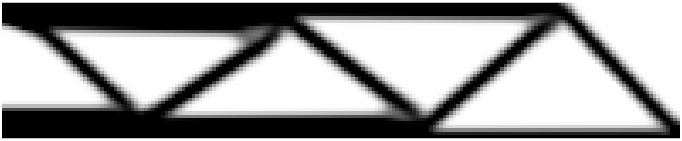

Output image after iterations

Matlab Images for reference

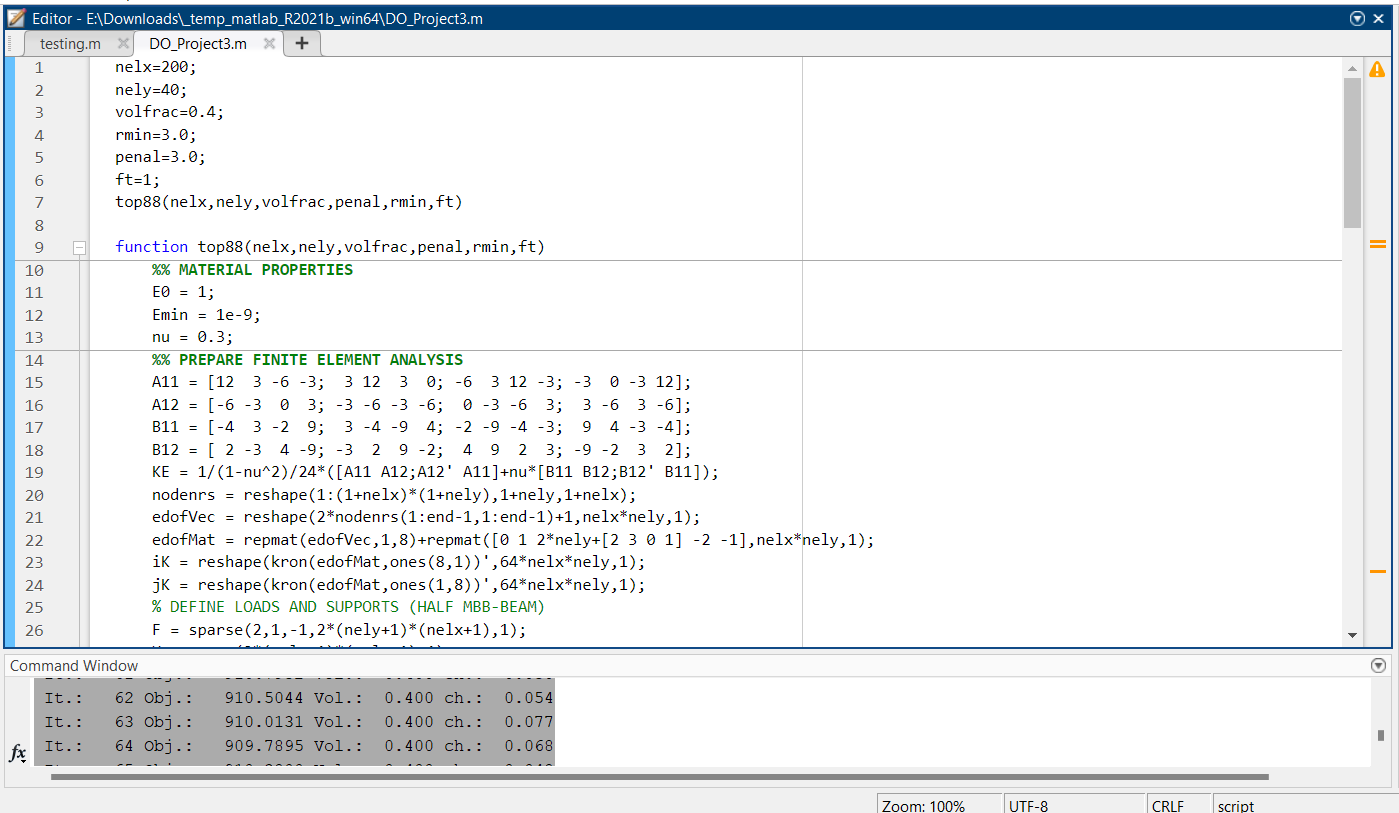

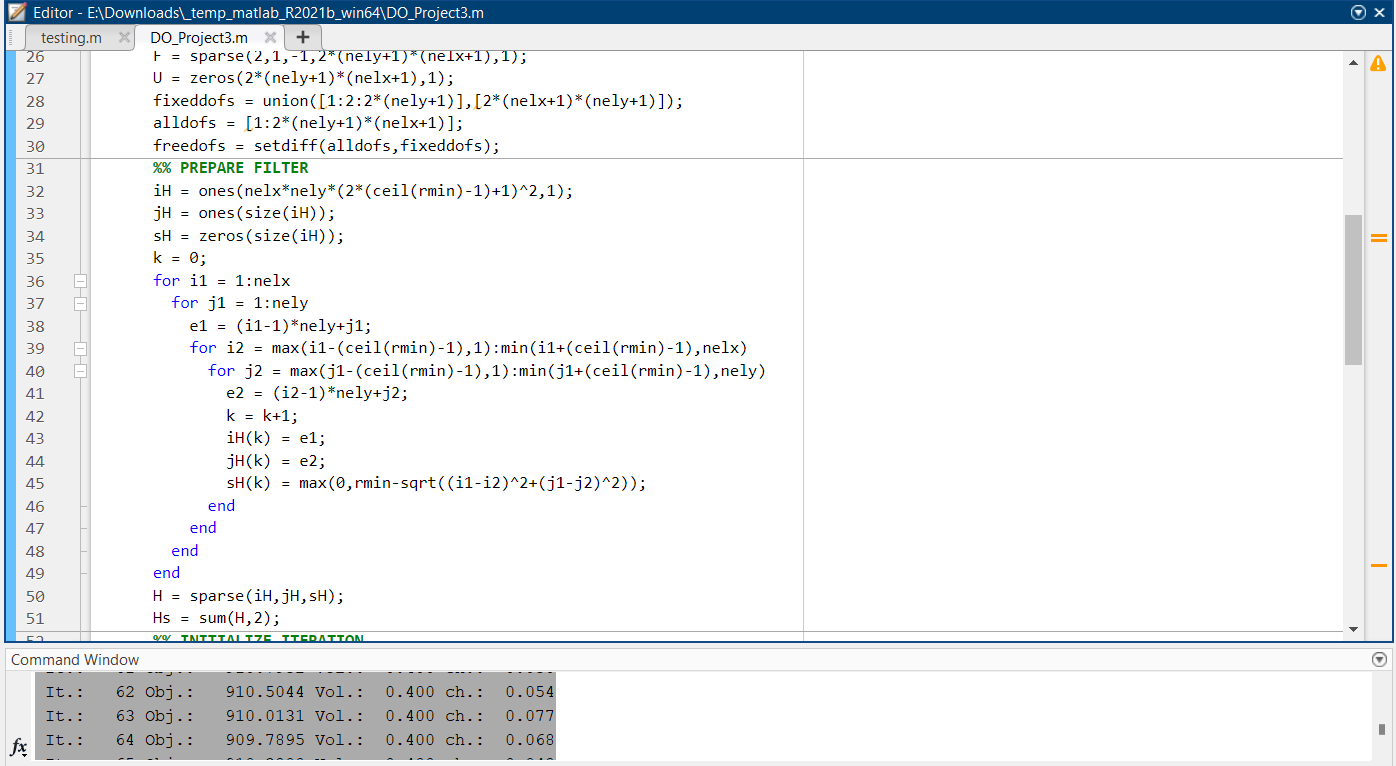

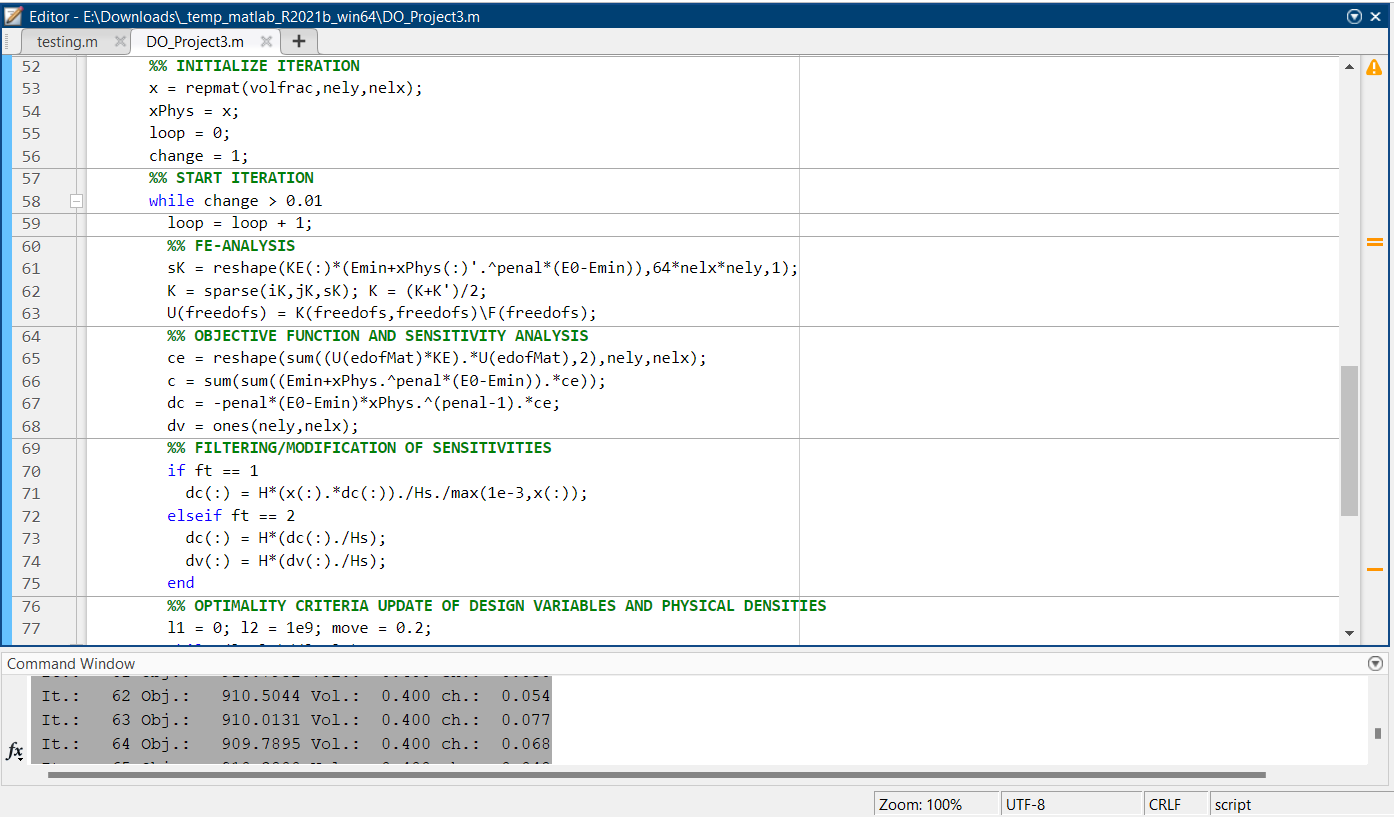

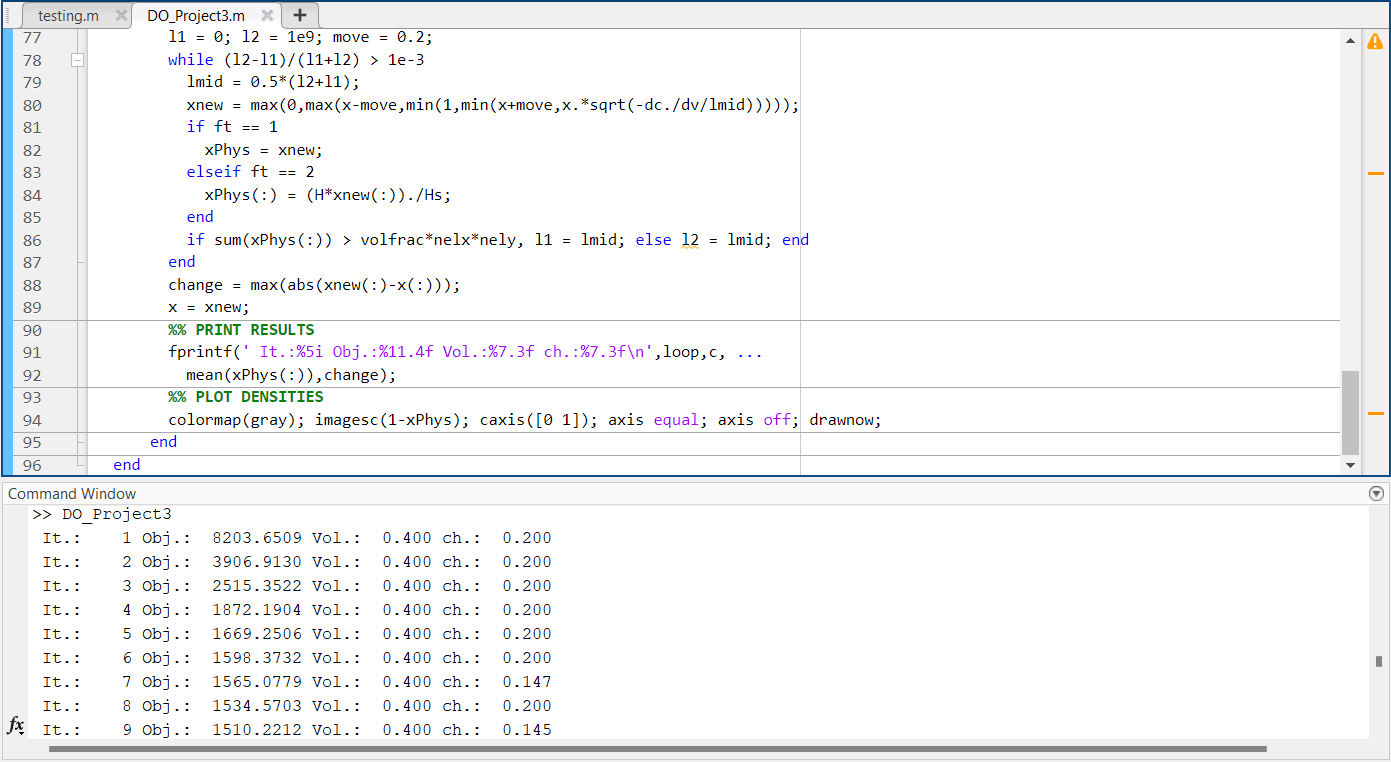


